# Playground Self Supervised Learning: Fashionset Classification

**Fashion MNIST** dataset ready in https://pytorch.org/docs/master/torchvision/datasets.html#fashion-mnist

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Define a transform to normalize the data
transform = Compose([ToTensor(), Normalize((0.5, ), (0.5, ))])

In [35]:
root_dir = 'fashion_mnist'


# Download and load the training data
trainset = FashionMNIST(root=root_dir, download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = FashionMNIST(root=root_dir, download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

In [36]:
image, label = trainset[0]
print(image.size())
print(label)

torch.Size([1, 28, 28])
9


In [7]:
#We can iterate over the dataset
for xs, ys in trainloader:
    print(xs.size(), ys.size())
    print(ys)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])
tensor([8, 0, 0, 3, 0, 5, 2, 2, 8, 6, 5, 1, 3, 2, 2, 1, 5, 5, 1, 2, 8, 3, 5, 2,
        2, 8, 3, 6, 7, 6, 2, 2, 7, 0, 8, 8, 0, 2, 5, 9, 2, 5, 1, 0, 7, 6, 3, 1,
        4, 9, 0, 2, 8, 6, 3, 1, 0, 3, 1, 4, 2, 0, 4, 4])


### Display random images

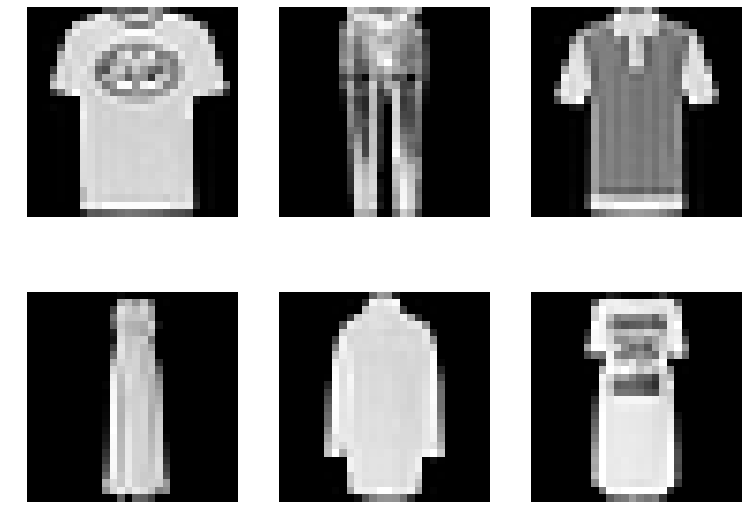

In [20]:
from matplotlib import pyplot as plt
from random import randint

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]
for i in range(6):
    index = randint(0, len(trainset))
    axes[i].imshow(trainset[index][0].view(28, 28), cmap='gray')
    axes[i].axis('off')    

### Random rotation

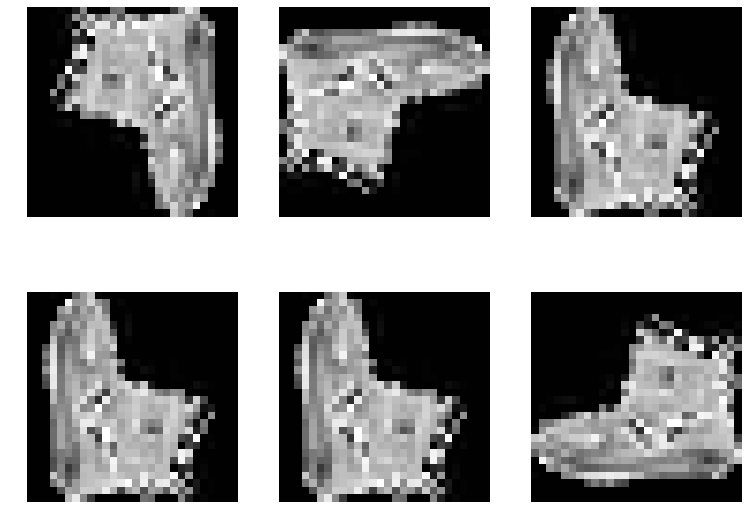

In [9]:
import torchvision.transforms.functional as TF
import random


transforms = ToPILImage()
    
f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    angle = random.choice([0, 90, 180, 270])
    axes[i].imshow(TF.rotate(transforms(trainset[0][0]), angle), cmap='gray')
    axes[i].axis('off') 

In [110]:
from torch.utils.data import Dataset

class FashionMinstAugmentedDataset(Dataset):

    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        datapoint = self.transform(self.data[index])

        return datapoint

In [118]:
def my_segmentation_transforms(image):
    angle = random.choice([0, 90, 180, 270])

    image = TF.to_pil_image(image[0])
    image = TF.rotate(image, angle)

    image = TF.to_tensor(image)
    image = TF.normalize(image, (0.5, ), (0.5, ))

    return image, angle

In [119]:
trainset_augmented = FashionMinstAugmentedDataset(trainset, transform=my_segmentation_transforms)
trainloader_augmented = DataLoader(trainset_augmented, batch_size=32, shuffle=True, num_workers=32)

torch.Size([1, 28, 28])
180


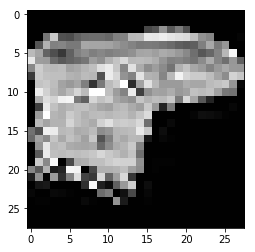

In [134]:
image, label = trainset_augmented[0]
plt.imshow(image.view(28, 28), cmap='gray')
print(image.size())
print(label)

In [135]:
#We can iterate over the dataset
for xs, ys in trainloader_augmented:
    print(xs.size(), ys.size())
    print(ys)
    break

torch.Size([32, 1, 28, 28]) torch.Size([32])
tensor([180, 180, 180,   0, 270, 180, 270, 270, 270, 180,  90, 270, 180, 270,
        180,  90,   0,  90,  90, 180, 270,  90, 180, 270,   0,  90,  90, 270,
        180, 180,  90, 270])


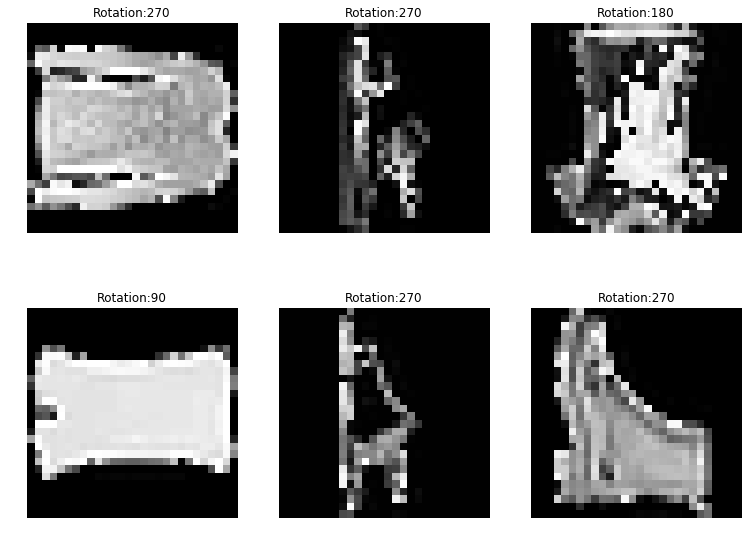

In [148]:
from matplotlib import pyplot as plt
from random import randint

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]
for i in range(6):
    index = randint(0, len(trainset_augmented))
    image, label = trainset_augmented[index]
    axes[i].imshow(np.asarray(image.view(28, 28)), cmap='gray')
    axes[i].set_title('Rotation:' + str(label))
    axes[i].axis('off')   

## Models